# XGBoost Classification Model

> you must run the data-science.ipynb first in order to get the experimental model

# Import packages

In [46]:
# load data
# Add directory above current directory to path
import sys; sys.path.insert(0, '..')
from submodules.load_data import load_data

# data manipulation
import numpy as np
import pandas as pd

# data splitting
from sklearn.model_selection import train_test_split

# data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# model
from xgboost import XGBClassifier

# hyperparameter tuning
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

# k-fold cross validation
from sklearn.model_selection import cross_validate

# saving models
import joblib

# performance
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt


# Load the data

Load semi-colon separated data from disk

In [47]:
#data = load_data()

csv_path = "../data/raw/dataSepsis.csv"
data = pd.read_csv(csv_path, sep=";")

# Create a Test Dataset

In [48]:
X_train, X_test, y_train, y_test = \
    train_test_split(data.drop(["Age", "Unit1", "Unit2", "HospAdmTime", "ICULOS", "Gender", "isSepsis"], axis=1),
    data["isSepsis"], test_size=0.2,
    random_state=42, stratify=data["isSepsis"])

# Transformation pipeline

In [49]:
pipeline = joblib.load("../data/transform/pipeline.pkl")

# Transform the data

In [50]:
X_train_prepared = pipeline.fit_transform(X_train)

# Load the model

In [51]:
# load the model from disk
model = joblib.load("../models/experiment/xgbc_model.pkl")

# Fine tune the Random Forest Classifier with Randomize Search Cross Validation

https://xgboost.readthedocs.io/en/latest/parameter.html


In [52]:
print("[INFO] setting hyperparameters...")
# general
booster = ["gbtree", "dart",]

use_label_encoder = [False]
eval_metric = ["mlogloss"]
# booster
eta = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0] # learning rate range [0, 1]
min_child_weight = [0, 1, 5, 15]# Used to control over-fitting. Higher values prevent a model from learning relations
gamma = [0, 5, 10, 20] # Makes the algorithm conservative
max_depth = [3, 4, 5, 6, 7, 8, 9, 10] # Used to control over-fitting as higher depth will allow model to learn relations very specific
subsample = [0.5, 0.7, 1] # Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
colsample_bytree = [0.5, 0.7, 1] # Denotes the fraction of columns to be randomly samples for each tree.
scale_pos_weight = [1, 2, 3] # A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence
tree_method = ["auto", "exact", "approx"]
# learning tasks
objective = ["binary:logistic", "binary:logitraw", "binary:hinge"]
eval_metric = ["mlogloss", "auc", "aucpr"]
grid = dict(eta=eta, min_child_weight=min_child_weight, gamma=gamma, max_depth=max_depth, subsample=subsample,
            colsample_bytree=colsample_bytree, scale_pos_weight=scale_pos_weight, tree_method=tree_method,
            objective=objective, eval_metric=eval_metric)

[INFO] setting hyperparameters...


In [53]:
# initialize a cross-validation fold and perform a randomized-search
# to tune the hyperparameters
print("[INFO] grid searching over the hyperparameters...")
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
randomSearch = RandomizedSearchCV(estimator=model, n_jobs=-1,
	cv=cvFold, param_distributions=grid,
	scoring="f1", return_train_score=True)
X_train = pipeline.fit_transform(X_train)
searchResults = randomSearch.fit(X_train_prepared, y_train)

[INFO] grid searching over the hyperparameters...


In [54]:
# print the best score
searchResults.best_score_

0.6060698382713998

In [55]:
# print the best combination of parameters
searchResults.best_params_

{'tree_method': 'auto',
 'subsample': 1,
 'scale_pos_weight': 3,
 'objective': 'binary:logitraw',
 'min_child_weight': 1,
 'max_depth': 6,
 'gamma': 20,
 'eval_metric': 'mlogloss',
 'eta': 1.0,
 'colsample_bytree': 0.5}

In [56]:
# print the best estimator directly
searchResults.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=1.0,
              eval_metric='mlogloss', gamma=20, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='binary:logitraw', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=3, subsample=1, tree_method='auto',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

XGBC Confusion Matrix
[[26488   435]
 [  850  1268]]


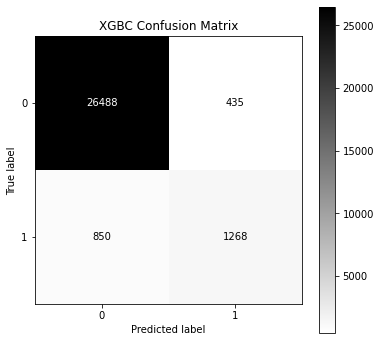

In [57]:
# confusion matrix with best_estimator_
title = "XGBC Confusion Matrix"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_confusion_matrix(searchResults.best_estimator_, X_train_prepared, y_train, cmap="binary", ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.savefig("../reports/figures/tune/xgbc_cm.png")

# Serialize the Model

In [58]:
# serialize the model
joblib.dump(searchResults.best_estimator_, "../models/tune/xgbc_model.pkl", compress=('bz2', 3))

['../models/tune/xgbc_model.pkl']

# Load the model

In [59]:
# load the model from disk
model = joblib.load("../models/tune/xgbc_model.pkl")

# Test the Model

In [60]:
X_test_prepared = pipeline.transform(X_test)

#### Confusion Matrix

XGBC Confusion Matrix
[[6596  136]
 [ 252  277]]


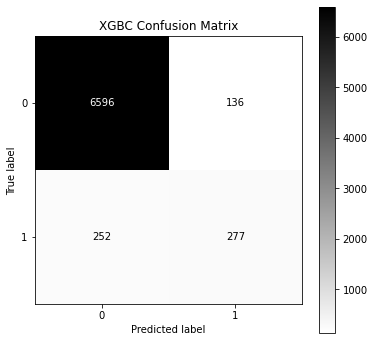

In [61]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

title = "XGBC Confusion Matrix"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_confusion_matrix(model, X_test_prepared, y_test, cmap="binary", ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.savefig("../reports/figures/final/xgbc_cm.png")

#### Precision Recall Curve

XGBC Precision Recall Curve
0.6239588151879718


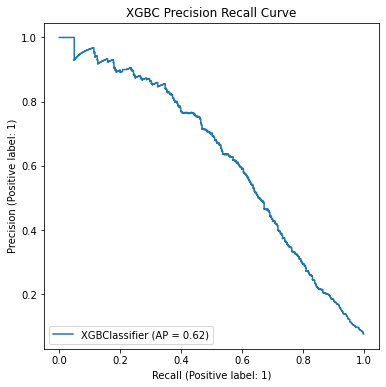

In [62]:
# computes a precision-recall curve from the ground truth label and a score given
# by the classifier by varying a decision threshold
title = "XGBC Precision Recall Curve"
fig, ax = plt.subplots(figsize=(6, 6))
disp = plot_precision_recall_curve(model, X_test_prepared, y_test, ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.average_precision)
#disp.ax_.set_title('Precision-Recall curve')
plt.savefig("../reports/figures/final/xgbc_prc.png")

In [63]:
# serialize the model
joblib.dump(model, "../models/final/xgbc_model.pkl", compress=('bz2', 3))

['../reports/figures/final/xgbc_model.pkl']